## `lab10`—Celestial Mechanics

❖ Objectives

-   Use $n$-dimensional arrays to manage state data.
-   Create a scientific model with a main loop.
-   Visualize results as plots.

In [1]:
# If you have to restart your kernel, come back to this cell to reload the basic modules.
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

The signal accomplishment of twentieth-century engineering is arguably the moon shot.  The required combination of finely-tuned instrumentation, enormous rockets for powered flight, and human daring is a monument of accomplishment.  One of the primary systems of the Apollo program was navigation—the calculation and realization of orbital mechanics and celestial maneuvering.  Today, you will model orbital mechanics in a multibody solar system.

A *body*, in this case, can refer to a planet, a star, a natural or artificial satellite, a rocket, a manned capsule, an asteroid, etc.  When we calculate the path of any body, all that matters are the *masses* and the *forces*.  We therefore have made two simplifying assumptions:

1.  The mass of a body is focussed at its center as a point mass in two dimensions.  (The main risk of this assumption is that we risk calculating one body entering the radius of another; we trust for this lab that distances are large.)
2.  Extremely heavy bodies may be treated as stationary.  (That is, the earth and a satellite mutually orbit their center of mass—but this point is trivially close to the earth's center of mass if the satellite is light.)

![](./img/bodies.png)

##  State

For each body, we need to keep track of two state variables:  mass $m$ and position $\vec{r} = (x, y)$.  We will store each body as a dictionary with entries for mass and position:

    body:
        'm' → float
        'x' → np.ndarray(dtype=float64)
        'y' → np.ndarray(dtype=float64)
        'vx' → np.ndarray(dtype=float64)
        'vy' → np.ndarray(dtype=float64)

Let's see how this works for a single body acted on by a uniform force.  (This is equivalent to the glass falling off of a table, only sideways and with no floor.  It's a different perspective on the homework problem.)

##  The Solar Sail:  A One-Body Problem

<img src="./img/IKAROS_solar_sail.jpg" width="40%">

<blockquote>
“Provide ships or sails adapted to the heavenly breezes, and there will be some who will brave even that void.”  (Johannes Kepler to Galileo Galilei, 1610)
</blockquote>

First, we need a way to model and track the motion of a single body acting under a force.  Consider, for instance, a solar sail being propelled by a the force of a uniform solar wind<sup>[[Wikipedia](https://en.wikipedia.org/wiki/Solar_sail)]</sup>.  Such a solar sail will experience a force on it of, say, 5 newtons for every 640,000 m<sup>2</sup> of area.  The acceleration the sail body experiences may be calculated according to Newton's second law:

$$F = ma$$

or, given the mass of the ultraefficient lattice sailer,
$$
m = 0.07\,\text{g}\cdot\text{m}^{-2} \times 6.4\cdot 10^{5} \,\text{m}^{2} = 4.48\cdot 10^{4} \,\text{g} = 44.8 \,\text{kg} \text{,}
$$
we find the acceleration to be
$$
a = F/m = (5 \,\text{N}) / (44.8 \,\text{kg}) = 0.1116\,\text{m}\cdot\text{s}^{-2} \text{.}
$$
(in reality, the conversion of light force to acceleration is not 100% efficient, but we will not include that effect in our calculation.)

-   Compose a function `accel` which accepts as parameters a variable `force` and a variable `mass`.  `accel` should `return` the acceleration resulting from force and mass according to Newton's second law.

In [2]:
# define your function here
def accel(force, mass):
    return force/mass

We explicitly require the function `accel` to pass the following unit tests:

| $F$ | $m$ | $a$ | Comment                     |
|-----|-----|-----|-----------------------------|
| 10  | 100 | 0.1 | Test of basic functionality |
| `np.linspace(0,10,11)` | 10 | `np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])` | Test for NumPy compatibility |

In [3]:
# it should pass this test---do NOT edit this cell
from numpy import isclose

test_force = 10
test_mass  = 100
test_accel = 0.1

assert isclose(accel(test_force, test_mass), test_accel)
print('Success!')

Success!


In [4]:
# it should pass this test---do NOT edit this cell
import numpy as np
from numpy.testing import assert_allclose

test_force = np.linspace(0,10,11)
test_mass  = 10
test_accel = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

test_results = accel(test_force, test_mass)
assert_allclose(test_accel, test_results)
print('Success!')

Success!


Given the equation of motion, we can now build a model for the motion of the solar sail.

The *state variables* we need to track are:

-   solar sail mass `m`—this is a single value
-   solar sail position `x,y`—these are arrays which will start at zero, but will be filled with the position of the sail at each time increment
-   solar sail velocity `vx,vy`—these are arrays which will start at zero, but will be filled with the velocity of the sail at each time increment
-   time increments `t`—this will be an array of the time increment at each step of the simulation

-   Create a dictionary named `sail` with the following key–value pairs.

| key    | value         |
|--------|---------------|
| `'m'`  | `44.8            # kg`  |
| `'x'`  | `np.zeros(1001)  # m`   |
| `'y'`  | `np.zeros(1001)  # m`   |
| `'vx'` | `np.zeros(1001)  # m/s` |
| `'vy'` | `np.zeros(1001)  # m/s` |

In [5]:
# create `sail` here
sail = {}
sail['m'] = 44.8
sail['x'] = np.zeros(1001)
sail['y'] = np.zeros(1001)
sail['vx'] = np.zeros(1001)
sail['vy'] = np.zeros(1001)

In [6]:
# it should pass this test---do NOT edit this cell
from numpy import isclose
assert isclose(sail['m'], 44.8)
assert 'x' in sail.keys()
assert 'y' in sail.keys()
assert 'vx' in sail.keys()
assert 'vy' in sail.keys()
print('Success!')

Success!


If we wish to calculate the position of the solar sail in this model as a function of time, we can simply loop through the model state.  For each time increment, we will solve the equation of motion (Newton's second law) for the sail at each step.

An outline of this process is:

    # Create solar sail body (position, velocity, mass)  DONE
    # Create array of time increments.
    # Integrate equations of motion forward (in a loop).
        # Calculate force on body.
        # Update position.
        # Update velocity.
        # Output the results.
    # Output final results.

-   Define an array of time increments `t`.  This should be a NumPy array ranging from 0.0 to 10.0 $\text{s}$ with gaps between values of `1e-2`.  You may accomplish this using either `np.linspace` or `np.arange`, but be sure both the left- and right-hand bounds are included in the final array `t`.

In [22]:
# define `t` here
#t = np.linspace(0.0, 10.0, 1001)
t = np.arange(0.0, 10.0, 1e-2)
t = np.append(t, [10.0])


In [23]:
# it should pass this test---do NOT edit this cell
from numpy import isclose
assert isclose(t[0], 0.0) and isclose(t[-1], 10.0) and len(t) == 1001
print('Success!')

Success!


Our main loop had four components within it:

    # Integrate equations of motion forward (in a loop).
        # Calculate force on body.
        # Update position.
        # Update velocity.
        # Output the results.

It's worth expanding on these a bit.  In the following, the subscript $i$ refers to the time increment, or the index in `t`.

**Force**.  In this case, our force is constant, $F_{i} = F = +5 \,\text{N}$ along the x-axis.

-   Compose a function `force` which accepts a parameter `t` and `return`s `(5.0, 0.0)` as an `array`.

In [25]:
# define `force` here
def force(t):
    return np.array([5.0, 0.0])

In [26]:
# it should pass this test---do NOT edit this cell
test_force = force(0.0)
assert type(test_force) == np.ndarray
from numpy import isclose
assert isclose(test_force[0], 5.0)
assert isclose(test_force[1], 0.0)
print('Success!')

Success!


**Position**.  The position will be calculated numerically as
$$
x_{i} = x_{i-1} + v_{x,i-1} \Delta t + \frac{F_x}{2 m} \Delta t^{2}  \\
y_{i} = y_{i-1} + v_{y,i-1} \Delta t + \frac{F_y}{2 m} \Delta t^{2} \text{.}
$$

-   Compose a function `posn` which accepts as parameters numbers `xold`, `yold`, `vxold`, `vyold`, `fx`, `fy`, `m`, and `dt`, where these are respectively the positions and velocities of time increment `i`, the force components $F_x$ and $F_y$, the mass $m$, and the difference between successive time increments $\Delta t$.  (That is, `xold` = $x_{i-1}$, `vxold` = $v_{x,i-1}$, and so forth.)
    
    `posn` should `return` a tuple containing the updated position `xnew, ynew` calculated according to the foregoing formula.

In [28]:
# define `posn` here
def posn(xold, yold, vxold, vyold, fx, fy, m, dt):
    xnew = xold + vxold*dt + fx/(2*m)*dt**2
    ynew = yold + vyold*dt + fy/(2*m)*dt**2
    
    return (xnew, ynew)

In [29]:
# it should pass this test---do NOT edit this cell
test_posn = posn(0,0,0,0,1,1,1,1e-2)
assert len(test_posn) == 2
from numpy import isclose
assert isclose(test_posn[0], 5e-5)
assert isclose(test_posn[1], 5e-5)
print('Success!')

Success!


In [30]:
# it should pass this test---do NOT edit this cell
test_posn = posn(0,0,1,0,10,1,1,1e-2)
from numpy import isclose
assert isclose(test_posn[0], 0.0105)
assert isclose(test_posn[1], 5e-5)
print('Success!')

Success!


**Velocity**.  The velocity will be calculated numerically as
$$
v_{x,i} = v_{x,i-1} + \frac{F_{x,i} + F_{x,i-1}}{2 m} \Delta t  \\
v_{y,i} = v_{y,i-1} + \frac{F_{y,i} + F_{y,i-1}}{2 m} \Delta t \text{.}
$$

-   Compose a function `vel` which accepts as parameters numbers `vxold`, `vyold`, `fxold`, `fyold`, `fxnew`, `fynew`, `m`, and `dt`, where these are respectively the velocities of time increment `i`, the force components $F_x$ and $F_y$ (updated and old), the mass $m$, and the difference between successive time increments $\Delta t$.  (That is, `vxold` = $v_{x,i-1}$ and so forth.)
    
    `vel` should `return` a tuple containing the updated velocity `vxnew, vynew` calculated according to the foregoing formula.

In [31]:
# define `vel` here
def  vel(vxold, vyold, fxold, fyold, fxnew, fynew, m, dt):
    vxnew = vxold + (fxold+fxnew)/(2*m)*dt
    vynew = vyold + (fyold+fynew)/(2*m)*dt
    
    return (vxnew, vynew)

In [32]:
# it should pass this test---do NOT edit this cell
test_vel = vel(0,0,5,0,5,0,1,1e-2)
assert len(test_vel) == 2
from numpy import isclose
assert isclose(test_vel[0], 5e-2)
assert isclose(test_vel[1], 0.0)
print('Success!')

Success!


In [33]:
# it should pass this test---do NOT edit this cell
test_vel = vel(0,0,5,0,-1,10,10,1e-3)
assert len(test_vel) == 2
from numpy import isclose
assert isclose(test_vel[0], 2e-4)
assert isclose(test_vel[1], 5e-4)
print('Success!')

Success!


**Output**.  This will consist of two pieces:  the arrays of positions and velocities in `sail`, and plots we will generate from those values.

-   Examine the main loop of the model below.  This will integrate the equations of motion forward, applying the force to the body and seeing what the changes in position and velocity are as a result of the force.
    
    We will consider the values in the first place in the position and velocity arrays to be the *initial condition*, so we can skip calculating them and instead use them during the second loop.

In [34]:
dt = t[1] - t[0]  # time increment size, s
nt = len(t)       # number of time steps

for i in range(nt):
    if i == 0:
        continue    # if first time step, we already have initial condition
    
    # Calculate force on body.
    F = force(t[i]) # force, N
    fx = F[0]   # force in the x-direction, N
    fy = F[1]   # force in the y-direction, N
    
    # Update position from velocity and force.
    xold  = sail['x'][i-1]  # old position along the x-axis, m
    yold  = sail['y'][i-1]  # old position along the y-axis, m
    vxold = sail['vx'][i-1] # old velocity in the x-direction, m/s
    vyold = sail['vy'][i-1] # old velocity in the y-direction, m/s
    m     = sail['m']       # mass, kg
    
    x, y = posn(xold, yold, vxold, vyold, fx, fy, m, dt)
    
    sail['x'][i] = x        # new position along the x-axis, m
    sail['y'][i] = y        # new position along the y-axis, m
    
    # Update velocity from force.
    fxold = fx  # force in the x-direction doesn't change in this example, N
    fyold = fy  # force in the y-direction doesn't change in this example, N
    fxnew = fx  #
    fynew = fy  #
    
    vx, vy = vel(vxold, vyold, fxold, fyold, fxnew, fynew, m, dt)
    
    sail['vx'][i] = vx      # new velocity along the x-axis, m
    sail['vy'][i] = vy      # new velocity along the y-axis, m
    
    # Output the results of this loop.
    print('time step %i completed; x-posn = %f'%(i,x))

time step 1 completed; x-posn = 0.000006
time step 2 completed; x-posn = 0.000022
time step 3 completed; x-posn = 0.000050
time step 4 completed; x-posn = 0.000089
time step 5 completed; x-posn = 0.000140
time step 6 completed; x-posn = 0.000201
time step 7 completed; x-posn = 0.000273
time step 8 completed; x-posn = 0.000357
time step 9 completed; x-posn = 0.000452
time step 10 completed; x-posn = 0.000558
time step 11 completed; x-posn = 0.000675
time step 12 completed; x-posn = 0.000804
time step 13 completed; x-posn = 0.000943
time step 14 completed; x-posn = 0.001094
time step 15 completed; x-posn = 0.001256
time step 16 completed; x-posn = 0.001429
time step 17 completed; x-posn = 0.001613
time step 18 completed; x-posn = 0.001808
time step 19 completed; x-posn = 0.002015
time step 20 completed; x-posn = 0.002232
time step 21 completed; x-posn = 0.002461
time step 22 completed; x-posn = 0.002701
time step 23 completed; x-posn = 0.002952
time step 24 completed; x-posn = 0.003214
t

-   Convert the foregoing block of code into a function `loop1` which accepts as parameter a time increment size `dt` and a function `force`.  `loop1` should `return` an array of times `times` and a sail body `body`.

In [37]:
def loop1(dt, force):
    # Create array of time increments.
    times = np.arange(0,10,dt)       #time increments between 0 to 10 sec
    nt = len(times) # number of time steps
    
    # Create solar sail body (position, velocity, mass=44.8)
    body = {}# you can use the code you wrote above here BUT USE nt FOR THE ARRAY SIZE, NOT 1001
    body['m'] = 44.8
    body['x'] = np.zeros(nt)
    body['y'] = np.zeros(nt)
    body['vx'] = np.zeros(nt)
    body['vy'] = np.zeros(nt)
    
    # Integrate equations of motion forward (in a loop).
    for i in range(nt):
        if i == 0:
            continue    # if first time step, we already have initial condition
        
        # you can copy from above and modify the code to work in this loop.
        # Calculate force on body.  MAKE SURE TO USE times AND NOT t
        # Update position.
        # Update velocity.
        
        # Calculate force on body.
        F = force(times[i]) # force, N
        fx = F[0]   # force in the x-direction, N
        fy = F[1]   # force in the y-direction, N

        # Update position from velocity and force.
        xold  = body['x'][i-1]  # old position along the x-axis, m
        yold  = body['y'][i-1]  # old position along the y-axis, m
        vxold = body['vx'][i-1] # old velocity in the x-direction, m/s
        vyold = body['vy'][i-1] # old velocity in the y-direction, m/s
        m     = body['m']       # mass, kg

        x, y = posn(xold, yold, vxold, vyold, fx, fy, m, dt)

        body['x'][i] = x        # new position along the x-axis, m
        body['y'][i] = y        # new position along the y-axis, m

        # Update velocity from force.
        fxold = fx  # force in the x-direction doesn't change in this example, N
        fyold = fy  # force in the y-direction doesn't change in this example, N
        fxnew = fx  #
        fynew = fy  #

        vx, vy = vel(vxold, vyold, fxold, fyold, fxnew, fynew, m, dt)

        body['vx'][i] = vx      # new velocity along the x-axis, m
        body['vy'][i] = vy      # new velocity along the y-axis, m
        
    return (times, body)

In [38]:
# loop1 test
t, sail = loop1(1e-2,force)

-   Plot the $x$- and $y$-position of the sail as a function of time increments `t`.  Note that the $y$-position remains zero throughout since no vertical forces are applied to the solar sail.

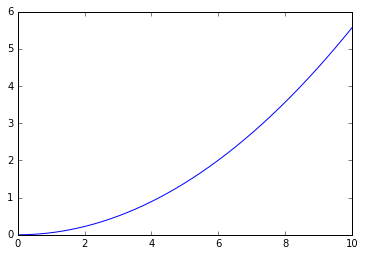

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(t, sail['x'], t, sail['y'])
plt.show()

-   Plot the $x$- and $y$-velocity of the sail as a function of time increments `t`.  As before, the $y$-component remains zero.

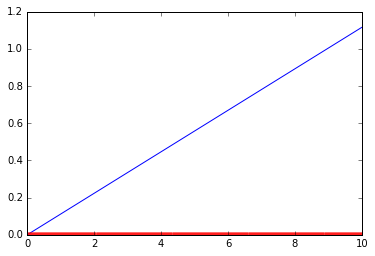

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

# YOU WRITE THE plt.plot STATEMENT
plt.plot(t, sail['vx'], t, sail['vy'], 'r+')
plt.show()

That's a pretty basic scenario, but what if we tilt the solar wind so that it blows athwart the sail *and* it increases gently over time?

-   Compose a *new* function `force2` which accepts a time `t`. `force2` should `return` the force components
    
    $$
    F = \left(5t , 0.01 t^{2}\right)
    $$
    
    as an `array`.

In [44]:
# define `force2` here
def force2(t):
    return np.array([5*t, 0.01*t**2])

In [45]:
# it should pass this test---do NOT edit this cell
test_force = force2(5)
assert type(test_force) == np.ndarray
from numpy import isclose
assert isclose(test_force[0], 25.0)
assert isclose(test_force[1], 0.25)
print('Success!')

Success!


In [46]:
t, sail = loop1(1e-3, force2)

-   Plot the $x$- and $y$-position of the sail as a function of time increments `t`.  Note that the $y$-position now varies from zero.

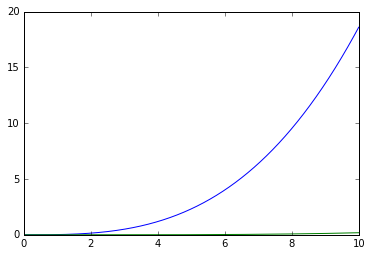

In [47]:
# YOU WRITE THE plt.plot STATEMENT

plt.plot(t, sail['x'], t, sail['y'])
plt.show()

-   Plot the $y$-position of the sail against the $x$-position of the sail.  This reproduces the path of the sail over time under the influence of the varying "solar wind" force.  (It's worth mentioning that the equation for `force2` we use here has no relation to the force of the actual solar wind; it's just illustrative.)

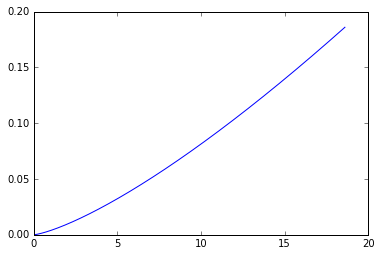

In [49]:
# YOU WRITE THE plt.plot STATEMENT

plt.plot(sail['x'],sail['y'])
plt.show()

##  Numerical Error & Convergence

Before we continue with more complex mechanics, let's take a brief look at numerical error.

If we plot the following curves on the same plot with differently-colored lines for each, we can see how the line slightly moves for each value.

In [71]:
(times1, sail1) = loop1(4e0, force2)
(times2, sail2) = loop1(2e0, force2)
(times3, sail3) = loop1(5e-1, force2)
(times4, sail4) = loop1(1e-1, force2)

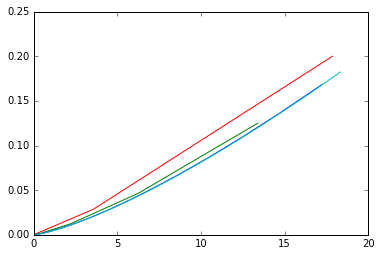

In [72]:
plt.plot(sail1['x'], sail1['y'], 'r',
         sail2['x'], sail2['y'], 'g',
         sail3['x'], sail3['y'], 'b',
         sail4['x'], sail4['y'], 'c')
plt.show()

Could you explain why the curves are not the same, and which curve is closest to the actual curve of such a satellite system?
And how do we decide which time increment size `dt` to use in the simulation? Please write down your answer in the following box (double click and type in):

##### My observations:






##  An Orbiting Satellite:  The Two-Body Problem

Next, we would like to simulate the orbit of a natural satellite around a planet.  We will call our bodies `planet` and `moon`.  The primary differences are that we have to loop over *two* bodies now, and we have to calculate a force due to gravity rather than just a simple force equation.

![](./img/moon.png)

The force due to gravity may be written:
$$
F = \frac{G m_\text{planet} m_\text{moon}}{r^2} \text{.}
$$

We provide a function `f_g` which accepts a planetary mass `m1`, a planetary position `x1`, `y1`, a lunar mass `m2`, and a lunar position `x2`, `y2`.  `f_g` `return`s the force due to gravity between those two bodies.

In [75]:
def f_g(m1, x1, y1, m2, x2, y2):
    r1 = np.array((x1,y1))
    r2 = np.array((x2,y2))
    d  = np.sqrt(np.sum((r2 - r1)**2))
    G  = 1.0  # the real value is 6.6726e-11 but that takes too long to solve
    
    F = -G * m1 * m2 / d**2 * (r2-r1)/d
    return F #F*(x2-x1), F*(y2-y1)

In [76]:
f_g(5.98e3, 0, 0, 6.38e-5, 10, 10)

array([-0.00134889, -0.00134889])

We provide the following script which allows us to relate the motions of these bodies to each other:

First, we establish the time increment array.  We'll use good variable names to construct this:

In [77]:
# Create array of time indices.
t_start = 0.0                      # initial time
t_end = 1000                       # final time
dt = 1e-1                          # time step size
t = np.arange(t_start, t_end, dt)  # array of time steps
nt = len(t)                        # number of time steps

Next, we create the bodies.  Specifying them grows more involved, since we have to specify $x$, $y$, $v_x$, $v_y$, and $m$ for each.  We also have to specify an initial condition:  the planet will be stationary, the moon will move at $24 \,\text{m}/\text{s}$ starting at $(+80,0)$.

In [78]:
# Create bodies for earth and moon.
planet = {'m':  1000,            # mass
          'x':  np.zeros( nt ),  # position along x-axis, m
          'y':  np.zeros( nt ),  # position along y-axis, m
          'vx': np.zeros( nt ),  # velocity along x-axis, m/s
          'vy': np.zeros( nt )   # velocity along y-axis, m/s
         }  # position history of planet
planet['x'][0]  = 0.0  # initial position along x-axis, m
planet['y'][0]  = 0.0  # initial position along y-axis, m
planet['vx'][0] = 0.0  # initial velocity along x-axis, m/s
planet['vy'][0] = 0.0  # initial velocity along y-axis, m/s

moon   = {'m':  1e-3,            # mass
          'x':  np.zeros( nt ),  # position along x-axis, m
          'y':  np.zeros( nt ),  # position along y-axis, m
          'vx': np.zeros( nt ),  # velocity along x-axis, m/s
          'vy': np.zeros( nt )   # velocity along y-axis, m/s
         }  # position history of planet
moon_vel = 24          # initial velocity of moon
moon['x'][0]  = 80.0   # initial position along x-axis, m
moon['y'][0]  =   0.0  # initial position along y-axis, m
moon['vx'][0] =   0.0  # initial velocity along x-axis, m/s
moon['vy'][0] = moon_vel*dt/2  # initial velocity along y-axis, m/s

Finally, we have the main loop which integrates the equations of motion.  Since we already wrote some functions to calculate the position and velocity subject to a force, we'll reuse those as well.

In [79]:
# Integrate equations of motion forward.
fx = 0
fy = 0
for i in range(nt):
    if i == 0:  # the initial condition can be skipped
        fx,fy = f_g(moon['m'], moon['x'][i], moon['y'][i], planet['m'], planet['x'][i], planet['y'][i])
        continue
    
    # Calculate forces on earth and moon
    fxold = fx  # old force in the x-direction, N
    fyold = fy  # old force in the y-direction, N
    fx,fy = f_g(planet['m'], planet['x'][i-1], planet['y'][i-1], moon['m'], moon['x'][i-1], moon['y'][i-1])
    
    # Update position of moon from velocity and force (earth is stationary since heavy)
    x, y = posn(moon['x'][i-1], moon['y'][i-1], moon['vx'][i-1], moon['vy'][i-1], fx, fy, moon['m'], dt)
    
    moon['x'][i] = x        # new position along the x-axis, m
    moon['y'][i] = y        # new position along the y-axis, m
    
    # Update velocity of moon from force.
    vx, vy = vel(moon['vx'][i-1], moon['vy'][i-1], fxold, fyold, fx, fy, moon['m'], dt)
    
    moon['vx'][i] = vx      # new velocity along the x-axis, m
    moon['vy'][i] = vy      # new velocity along the y-axis, m
    
    # Output the results of this loop.
    print('time step %i completed; time %f; x-posn = %f'%(i,t[i],x))

time step 1 completed; time 0.100000; x-posn = 79.999219
time step 2 completed; time 0.200000; x-posn = 79.998437
time step 3 completed; time 0.300000; x-posn = 79.996094
time step 4 completed; time 0.400000; x-posn = 79.992187
time step 5 completed; time 0.500000; x-posn = 79.986718
time step 6 completed; time 0.600000; x-posn = 79.979687
time step 7 completed; time 0.700000; x-posn = 79.971092
time step 8 completed; time 0.800000; x-posn = 79.960934
time step 9 completed; time 0.900000; x-posn = 79.949213
time step 10 completed; time 1.000000; x-posn = 79.935928
time step 11 completed; time 1.100000; x-posn = 79.921079
time step 12 completed; time 1.200000; x-posn = 79.904666
time step 13 completed; time 1.300000; x-posn = 79.886687
time step 14 completed; time 1.400000; x-posn = 79.867143
time step 15 completed; time 1.500000; x-posn = 79.846033
time step 16 completed; time 1.600000; x-posn = 79.823357
time step 17 completed; time 1.700000; x-posn = 79.799113
time step 18 completed;

Visually, this generates a slightly decaying orbit:

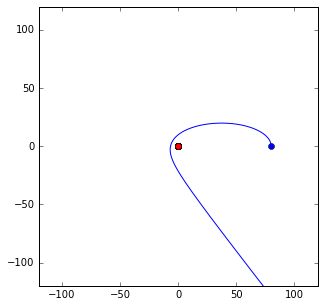

In [80]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.figsize'] = 5,5  # controls the figure size
plt.plot(moon['x'],   moon['y'],   'b-',  # mark the path of the moon
         planet['x'], planet['y'], 'ro',  # mark the position of the planet
         moon['x'][0],moon['y'][0],'bo')  # mark the initial position of the moon
lim = moon['x'][0] * 1.5
plt.xlim((-lim,lim))  # change the x-limits of the plot to make the whole orbit visible
plt.ylim((-lim,lim))  # change the y-limits of the plot to make the whole orbit visible

plt.show()

-   Convert the foregoing blocks of code into a function `loop2` which accepts parameters `dt`, `t_end`, and `velocity`, respectively the time increment, the maximum time, and the initial velocity.  `loop2` should `return` a tuple containing `times`, `moon`, and `planet`.

In [128]:
def loop2(dt, t_end, velocity):
    # Create array of time indices.
    t_start = 0.0                      # initial time
    times = np.arange(t_start, t_end, dt)  # array of time steps
    nt = len(times)                        # number of time steps
    
    # Create bodies for earth and moon.
    planet = {'m':  1000,            # mass
              'x':  np.zeros( nt ),  # position along x-axis, m
              'y':  np.zeros( nt ),  # position along y-axis, m
              'vx': np.zeros( nt ),  # velocity along x-axis, m/s
              'vy': np.zeros( nt )   # velocity along y-axis, m/s
             }  # position history of planet
    planet['x'][0]  = 0.0  # initial position along x-axis, m
    planet['y'][0]  = 0.0  # initial position along y-axis, m
    planet['vx'][0] = 0.0  # initial velocity along x-axis, m/s
    planet['vy'][0] = 0.0  # initial velocity along y-axis, m/s

    moon   = {'m':  1e-3,            # mass
              'x':  np.zeros( nt ),  # position along x-axis, m
              'y':  np.zeros( nt ),  # position along y-axis, m
              'vx': np.zeros( nt ),  # velocity along x-axis, m/s
              'vy': np.zeros( nt )   # velocity along y-axis, m/s
             }  # position history of planet
    moon_vel = 24          # initial velocity of moon
    moon['x'][0]  = 80.0   # initial position along x-axis, m
    moon['y'][0]  =   0.0  # initial position along y-axis, m
    moon['vx'][0] =   0.0  # initial velocity along x-axis, m/s
    moon['vy'][0] = moon_vel*dt/2  # initial velocity along y-axis, m/s
    
    # Integrate equations of motion forward.
    fx = 0
    fy = 0
    for i in range(nt):
        if i == 0:  # the initial condition can be skipped
            fx,fy = f_g(moon['m'], moon['x'][i], moon['y'][i], planet['m'], planet['x'][i], planet['y'][i])
            continue

        # Calculate forces on earth and moon
        fxold = fx  # old force in the x-direction, N
        fyold = fy  # old force in the y-direction, N
        fx,fy = f_g(planet['m'], planet['x'][i-1], planet['y'][i-1], moon['m'], moon['x'][i-1], moon['y'][i-1])

        # Update position of moon from velocity and force (earth is stationary since heavy)
        x, y = posn(moon['x'][i-1], moon['y'][i-1], moon['vx'][i-1], moon['vy'][i-1], fx, fy, moon['m'], dt)

        moon['x'][i] = x        # new position along the x-axis, m
        moon['y'][i] = y        # new position along the y-axis, m

        # Update velocity of moon from force.
        vx, vy = vel(moon['vx'][i-1], moon['vy'][i-1], fxold, fyold, fx, fy, moon['m'], dt)

        moon['vx'][i] = vx      # new velocity along the x-axis, m
        moon['vy'][i] = vy      # new velocity along the y-axis, m
        
    return times, moon, planet

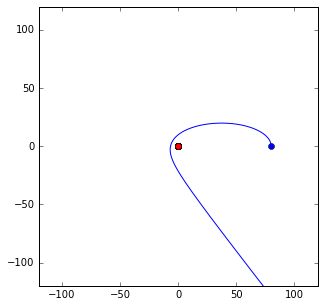

In [130]:
# As you test this function, you can use this cell.
# You should stick to dt around 0.1 (1e-1) and t_end < 1000 or your code may take too long to run.
test_t, test_m, test_p = loop2(1e-1, 100, 24)

plt.plot(test_m['x'],   test_m['y'],   'b-',  # mark the path of the moon
         test_p['x'],   test_p['y'],   'ro',  # mark the position of the planet
         test_m['x'][0],test_m['y'][0],'bo')  # mark the initial position of the moon
lim = moon['x'][0] * 1.5
plt.xlim((-lim,lim))  # change the x-limits of the plot to make the whole orbit visible
plt.ylim((-lim,lim))  # change the y-limits of the plot to make the whole orbit visible

plt.show()

You should expect to see the same plot as the previous one.

In [84]:
# it should pass this test---do NOT edit this cell
from numpy import isclose
t,m,p = loop2(1e-1, 100, 10)
assert len(t) == 1000
assert isclose(m['vx'][14],-0.20329873009101182,rtol=1e-3)
print('Success!')

Success!


If you play with the parameters, you can find a number of different scenarios, ranging from decaying orbits to escape velocities to gravitational slingshots (which are used to propel satellites into deep space):

<table>
<tr>
<td>
<img src="./img/moon-1e-1-24.png" width="100%">
</td>
<td>
<img src="./img/moon-1e-1-27.png" width="100%">
</td>
</tr>
<tr>
<td>
<img src="./img/moon-1e-1-31.png" width="100%">
</td>
<td>
<img src="./img/moon-1e-1-24n.png" width="100%">
</td>
</tr>
</table>

(The weird shot out at from the collision in the upper left image is a result of a division by zero as the distance between bodies goes to zero.  In reality, of course, the objects would collide.)

<div class="alert alert-info">
Hurray! There is no more coding required of you after this point—the rest of the lab is informational.
</div>

##  The $n$-Body Problem

When we move into the realm of many-body calculations, it soon becomes cumbersome to maintain separate variable names for each variable.

As any significant calculation will involves multiple bodies, we would maintain a list of bodies called `bodies` which contains the dictionaries with each body's properties.

We provide a code which accomplishes this for three bodies below.  (There is no more coding in this lab, so don't worry about time now.)  Note that the data structure is getting pretty complicated:  a `list` of bodies, each a `dict` containing `array`s.

In [138]:
# Create array of time indices.
t_start = 0.0                           # initial time
t_end = 150                              # final time
dt = 1e-2                               # time step size
times = np.arange(t_start, t_end, dt)   # array of time steps
nt = len(times)                         # number of time steps

In [145]:
# Create three orbiting bodies.
bodies = []

planet = {'m':  1000,            # mass
          'x':  np.zeros( nt ),  # position along x-axis, m
          'y':  np.zeros( nt ),  # position along y-axis, m
          'vx': np.zeros( nt ),  # velocity along x-axis, m/s
          'vy': np.zeros( nt )   # velocity along y-axis, m/s
         }  # position history of planet
planet['x'][0]  = 0.0  # initial position along x-axis, m
planet['y'][0]  = 0.0  # initial position along y-axis, m
planet['vx'][0] = 0.0  # initial velocity along x-axis, m/s
planet['vy'][0] = 0.0  # initial velocity along y-axis, m/s
bodies.append(planet)

moon   = {'m':  1e-2,            # mass
          'x':  np.zeros( nt ),  # position along x-axis, m
          'y':  np.zeros( nt ),  # position along y-axis, m
          'vx': np.zeros( nt ),  # velocity along x-axis, m/s
          'vy': np.zeros( nt )   # velocity along y-axis, m/s
         }  # position history of planet
moon_vel = 120         # initial velocity of moon
moon['x'][0]  =   0.0  # initial position along x-axis, m
moon['y'][0]  = 100.0  # initial position along y-axis, m
moon['vx'][0] = moon_vel*dt  # initial velocity along x-axis, m/s
moon['vy'][0] =   0.0  # initial velocity along y-axis, m/s
bodies.append(moon)

caps   = {'m':  2e-3,            # mass
          'x':  np.zeros( nt ),  # position along x-axis, m
          'y':  np.zeros( nt ),  # position along y-axis, m
          'vx': np.zeros( nt ),  # velocity along x-axis, m/s
          'vy': np.zeros( nt )   # velocity along y-axis, m/s
         }  # position history of planet
caps_vel = 300.0                      # initial velocity of caps
caps['x'][0] = -10.0    # initial position
caps['y'][0] = 0.0      # initial velocity
caps['vx'][0] = 0.0  # initial velocity along x-axis, m/s
caps['vy'][0] = caps_vel*dt   # initial velocity along y-axis, m/s
bodies.append(caps)

In [146]:
# initial forces
fx = np.zeros( len(bodies) )
fy = np.zeros( len(bodies) )
for body_j in range(len(bodies)):
        for body_k in range(body_j+1, len(bodies)):
            this_fx, this_fy = f_g(bodies[body_j]['m'], bodies[body_j]['x'][0], bodies[body_j]['y'][0],
                                   bodies[body_k]['m'], bodies[body_k]['x'][0], bodies[body_k]['y'][0])
            fx[body_j] -= this_fx
            fy[body_j] -= this_fy
            fx[body_k] += this_fx
            fy[body_k] += this_fy

# Integrate equations of motion forward.
for i in range(nt):
    if i == 0:
        continue    # if first time step, we already have initial condition
    
    # Calculate forces on bodies.
    fxold = fx  # old force in the x-direction, N
    fyold = fy  # old force in the y-direction, N
    fx = np.zeros( len(bodies) )
    fy = np.zeros( len(bodies) )
    for body_j in range(len(bodies)):
        for body_k in range(body_j+1, len(bodies)):
            this_fx, this_fy = f_g(bodies[body_j]['m'], bodies[body_j]['x'][i-1], bodies[body_j]['y'][i-1],
                                   bodies[body_k]['m'], bodies[body_k]['x'][i-1], bodies[body_k]['y'][i-1])
            fx[body_j] -= this_fx
            fy[body_j] -= this_fy
            fx[body_k] += this_fx
            fy[body_k] += this_fy
    
    # Update position of satellites (earth is stationary)
    for body_j in range(len(bodies)):
        x, y = posn(bodies[body_j]['x'][i-1],  bodies[body_j]['y'][i-1],
                    bodies[body_j]['vx'][i-1], bodies[body_j]['vy'][i-1],
                    fx[body_j], fy[body_j],    bodies[body_j]['m'], dt)
        bodies[body_j]['x'][i] = x
        bodies[body_j]['y'][i] = y
    
    # Update velocity of satellites from force.
    for body_j in range(len(bodies)):
        vx, vy = vel(bodies[body_j]['vx'][i-1], bodies[body_j]['vy'][i-1],
                     fxold[body_j], fyold[body_j],
                     fx[body_j], fy[body_j],
                     moon['m'], dt)
        bodies[body_j]['vx'][i] = vx
        bodies[body_j]['vy'][i] = vy
    
    # Output the results of this loop.
    if (i % 100 == 0):
        print('time step %i completed; time %f; x-posn = %f'%(i,times[i],bodies[1]['x'][i]))

time step 100 completed; time 1.000000; x-posn = 1.199726
time step 200 completed; time 2.000000; x-posn = 2.396978
time step 300 completed; time 3.000000; x-posn = 3.587411
time step 400 completed; time 4.000000; x-posn = 4.771779
time step 500 completed; time 5.000000; x-posn = 5.952357
time step 600 completed; time 6.000000; x-posn = 7.130511
time step 700 completed; time 7.000000; x-posn = 8.306985
time step 800 completed; time 8.000000; x-posn = 9.481987
time step 900 completed; time 9.000000; x-posn = 10.655165
time step 1000 completed; time 10.000000; x-posn = 11.825514
time step 1100 completed; time 11.000000; x-posn = 12.991175
time step 1200 completed; time 12.000000; x-posn = 14.149094
time step 1300 completed; time 13.000000; x-posn = 15.294421
time step 1400 completed; time 14.000000; x-posn = 16.419452
time step 1500 completed; time 15.000000; x-posn = 17.511653
time step 1600 completed; time 16.000000; x-posn = 18.549717
time step 1700 completed; time 17.000000; x-posn =

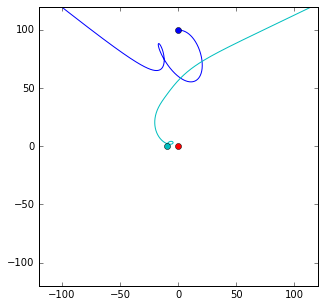

In [147]:
planet = bodies[0]
moon   = bodies[1]
caps   = bodies[2]

import matplotlib.pyplot as plt
plt.plot(moon['x'],     moon['y'],     'b-',
         moon['x'][0],  moon['y'][0],  'bo',
         planet['x'][0], planet['y'][0], 'ro',
         caps['x'],     caps['y'],     'c-',
         caps['x'][0],  caps['y'][0],  'co')
plt.xlim((-120,120))
plt.ylim((-120,120))
plt.show()

Although in the interest of time we will not generalize this problem further, you should be able to take the three-body problem and generalize it to simulate as many bodies (satellites, planets, rockets) as you like.

Since there is no analytical solution to the $n$-body problem, and it is well-characterized by Newton's laws, the $n$-body problem has long stood as a challenge of numerical accuracy<sup>[[UMN](https://web.archive.org/web/20010220232131/http://www.geom.umn.edu/~megraw/CR3BP_html/cr3bp.html)]</sup>.

In practice, astronomers and space scientists do not often start from Newton's equation of motion (the second law) to calculate the position of planets and other celestial bodies.  This is because this approach neglects the relative importance of different scale factors (a numerical problem).  More often, they assume that the orbits are Keplerian and then calculate small perturbative corrections to them.

If you have time left, you're encouraged to try different parameters (velocity, mass, position) of the bodies (planet, moon, caps) and see the different orbiting behaviors in the plot. And try to explain the resultant trajectories on your own.